In [1]:
import torch
import pytorch_lightning as pl

device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

from hydra.experimental import initialize, compose
from hydra.utils import instantiate

import numpy as np
import time 
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(184)
np.random.seed(143)

print(torch.__version__)
print(device)

1.8.1+cu102
cuda:6


In [2]:
datasetfrom bliss import sleep
from bliss.datasets import simulated

In [3]:
import sys
sys.path.append('../starnet_utils/')
import m2_data
import plotting
# import starnet_metrics
import daophot_utils
import utils

In [4]:
%matplotlib inline

# Load configs and starnet model

In [5]:
with initialize(config_path='./scripts/'):
    cfg = compose("decaps")

print('config: ')
print(cfg)


config: 
{'mode': 'train', 'gpus': 1, 'paths': {'root': None, 'output': '${paths.root}/output', 'sdss': '${paths.root}/data/sdss', 'data': '${paths.root}/data'}, 'datasets': {'simulated_m2': {'_target_': 'bliss.datasets.simulated.SimulatedDataset', 'prior': '${models.prior}', 'decoder': '${models.decoder}', 'background': [667.0, 496.0], 'n_batches': 40, 'batch_size': 4, 'generate_device': 'cuda:0', 'testing_file': None}}, 'models': {'decoder': {'_target_': 'bliss.models.decoder.ImageDecoder', 'n_bands': 2, 'tile_slen': 10, 'ptile_slen': 30, 'border_padding': 5, 'psf_params_file': '../psf/ziband_psf_fitted.npy', 'sdss_bands': [2, 3]}, 'encoder': {'_target_': 'bliss.models.location_encoder.LocationEncoder', 'n_bands': '${models.decoder.n_bands}', 'tile_slen': '${models.decoder.tile_slen}', 'ptile_slen': 20, 'max_detections': 3, 'channel': 17, 'spatial_dropout': 0.11399, 'dropout': 0.013123, 'hidden': 185}, 'prior': {'_target_': 'bliss.models.prior.ImagePrior', 'n_bands': 2, 'slen': 300, 

/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/initialize.py:35: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  warnings.warn(
/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/compose.py:16: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  warnings.warn(


In [6]:
cfg.models.decoder.psf_params_file = './psf/ziband_psf_fitted.npy'

In [7]:
dataset = instantiate(cfg.training.dataset)
sleep_net = instantiate(cfg.training.model,
                        optimizer_params=cfg.training.optimizer_params)

In [8]:
model_filename = './fits/starnet-tmp'
sleep_net.image_encoder.load_state_dict(torch.load(model_filename)); 

In [9]:
def get_map_estimate(image_encoder, images, background, slen: int, wlen: int = None):
    # return full estimate of parameters in full image.
    # NOTE: slen*wlen is size of the image without border padding

    if wlen is None:
        wlen = slen
    assert isinstance(slen, int) and isinstance(wlen, int)
    # check image compatibility
    border1 = (images.shape[-2] - slen) / 2
    border2 = (images.shape[-1] - wlen) / 2
    assert border1 == border2, "border paddings on each dimension differ."
    assert slen % image_encoder.tile_slen == 0, "incompatible slen"
    assert wlen % image_encoder.tile_slen == 0, "incompatible wlen"
    assert border1 == image_encoder.border_padding, "incompatible border"

    # obtained estimates per tile, then on full image.
    log_images = subtract_bg_and_log_transform(images, background)
    log_image_ptiles = get_images_in_tiles(
        log_images, image_encoder.tile_slen, image_encoder.ptile_slen
    )
    var_params = image_encoder.encode(log_image_ptiles)
    # var_params2 = image_encoder.encode(log_image_ptiles[:, :25, :25])
    # assert torch.allclose(var_params[0, :25, :25], var_params2, atol=1e-5)
    tile_map = image_encoder.max_a_post(var_params)

    return get_full_params_from_tiles(tile_map, image_encoder.tile_slen)

In [10]:
sleep_net.image_encoder.to(device);

In [11]:
from bliss.models.location_encoder import (
    get_full_params_from_tiles,
    get_images_in_tiles,
    subtract_bg_and_log_transform,
)

In [12]:
sleep_net.train();

for i in range(20): 
    print(i)
    batch = dataset.get_batch()
    tmp = batch['images'].to(device)
    map_est_sleep = get_map_estimate(sleep_net.image_encoder,
                                     tmp,
                                     dataset.background.view(1, 2, 1, 1).to(device), 
                                     slen = 300)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [13]:
sleep_net.image_encoder.to(device);
sleep_net.image_encoder.eval(); 

In [14]:
border_padding = sleep_net.image_encoder.border_padding

# load data

In [15]:
# from astropy.io import fits
# hdul = fits.open('../../../../decaps/data/decaps_l0_b0_hdu08_z')

# image = torch.Tensor(hdul[1].data).unsqueeze(0).unsqueeze(0)

# slen = 300
# x0 = 20
# x1 = 20

In [16]:
# out = dataset.get_batch()
# image = out['images']

# slen = 300
# x0 = border_padding
# x1 = border_padding

In [58]:
image = torch.Tensor(np.load('./alignment_data/aligned_image_zi.npy'))

slen = 1000
x0 = 3000
x1 = 1000

In [59]:
test_image = plotting.crop_image(image, 
                                 x0 - border_padding, 
                                 x1 - border_padding,
                                 slen + 2 * border_padding,
                                 slen + 2 * border_padding)

In [60]:
sleep_net.image_encoder.border_padding

5

In [61]:
test_image.shape

torch.Size([1, 2, 1010, 1010])

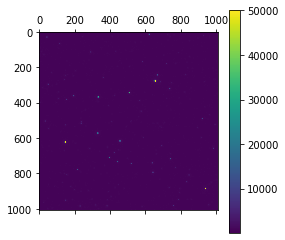

In [62]:
plt.matshow(test_image.cpu().numpy()[0, 0])
plt.colorbar()

# Get starnet map estimates

In [63]:
map_estimate = map_est_sleep = get_map_estimate(sleep_net.image_encoder, 
                                                test_image.to(device),
                                                dataset.background.view(1, 2, 1, 1).to(device), 
                                                slen = 1000)

# detach 
for key in map_estimate.keys(): 
    map_estimate[key] = map_estimate[key].squeeze(0).cpu().detach()

# reparameterize locations: these are coordinates on the frame
map_estimate['locs'] = map_estimate['locs'] * slen + \
    torch.Tensor([[x0, x1]])

# all galaxies should be off
# assert torch.all(map_estimate['galaxy_bool'] == 0.)

(array([[  0., 182., 185., 127., 113.,  80.,  58.,  20.,  21.,   8.],
        [135., 161., 128., 112.,  95.,  75.,  40.,  21.,  17.,  10.]]),
 array([2.4302144, 2.8028467, 3.1754792, 3.5481114, 3.920744 , 4.293376 ,
        4.6660085, 5.038641 , 5.4112735, 5.7839055, 6.156538 ],
       dtype=float32),
 <a list of 2 BarContainer objects>)

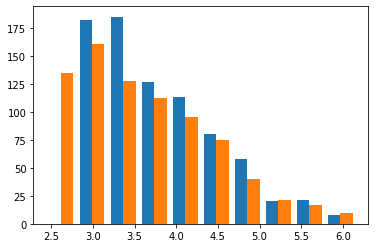

In [64]:
plt.hist(np.log10(map_estimate['fluxes'].squeeze().numpy()))

In [65]:
map_estimate['fluxes'].min()

tensor(269.2864)

### Check the coverage

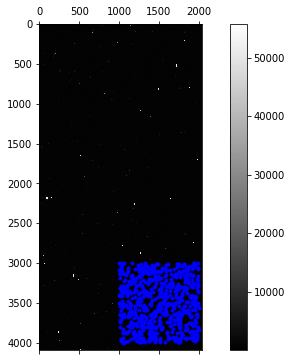

In [66]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))


plotting.plot_locations(
        map_estimate['locs'], 
        ax,
        marker='.',
        color='b', 
    )

im = plotting.plot_image(ax, image[0, 0])

f.colorbar(im, ax = ax)

[]

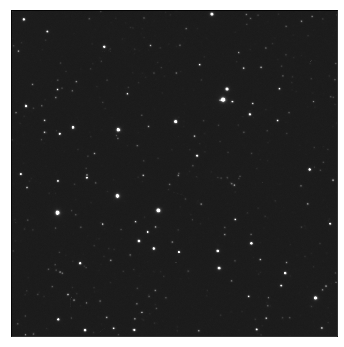

In [67]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))

im = plotting.plot_image(ax, image[0, 0, 3000:4000, 1000:2000].clip(max = 5000))

# f.colorbar(im, ax = ax)
ax.set_yticks([])
ax.set_xticks([])

# f.savefig('../figures/decaps/example_subimage1000_decaps.png')

In [70]:
x1

1000

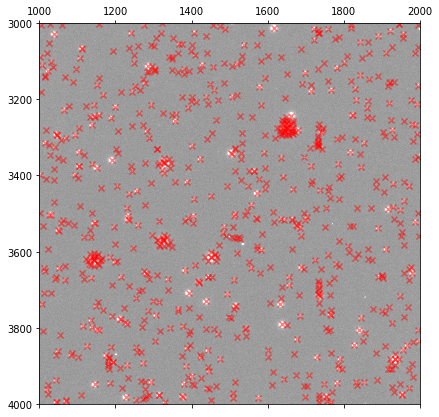

In [71]:
f, axarr = plt.subplots(1, 1, figsize=(8, 7))

plotting.plot_locations(
    map_estimate['locs'], 
    axarr,
    alpha = 0.5,
    marker='x',
    color='r',
)


im = plotting.plot_image(axarr, 
                         image[0, 0].clip(max = 1000), 
                         x0, 
                         x1,
                         slen,
                         slen)

f.colorbar(im, ax = ax)

In [28]:
# f, axarr = plt.subplots(1, 1, figsize=(4, 3))

# plotting.plot_locations(
#     map_estimate['locs'], 
#     axarr,
#     marker='x',
#     color='r',
# )

# # _x0 = 123
# # _x1 = 295
# _x0 = 236
# _x1 = 57

# subimage_slen = 20


# im = plotting.plot_image(axarr, 
#                          image[0, 0], 
#                          _x0, 
#                          _x1,
#                          subimage_slen,
#                          subimage_slen)

# f.colorbar(im, ax = axarr)

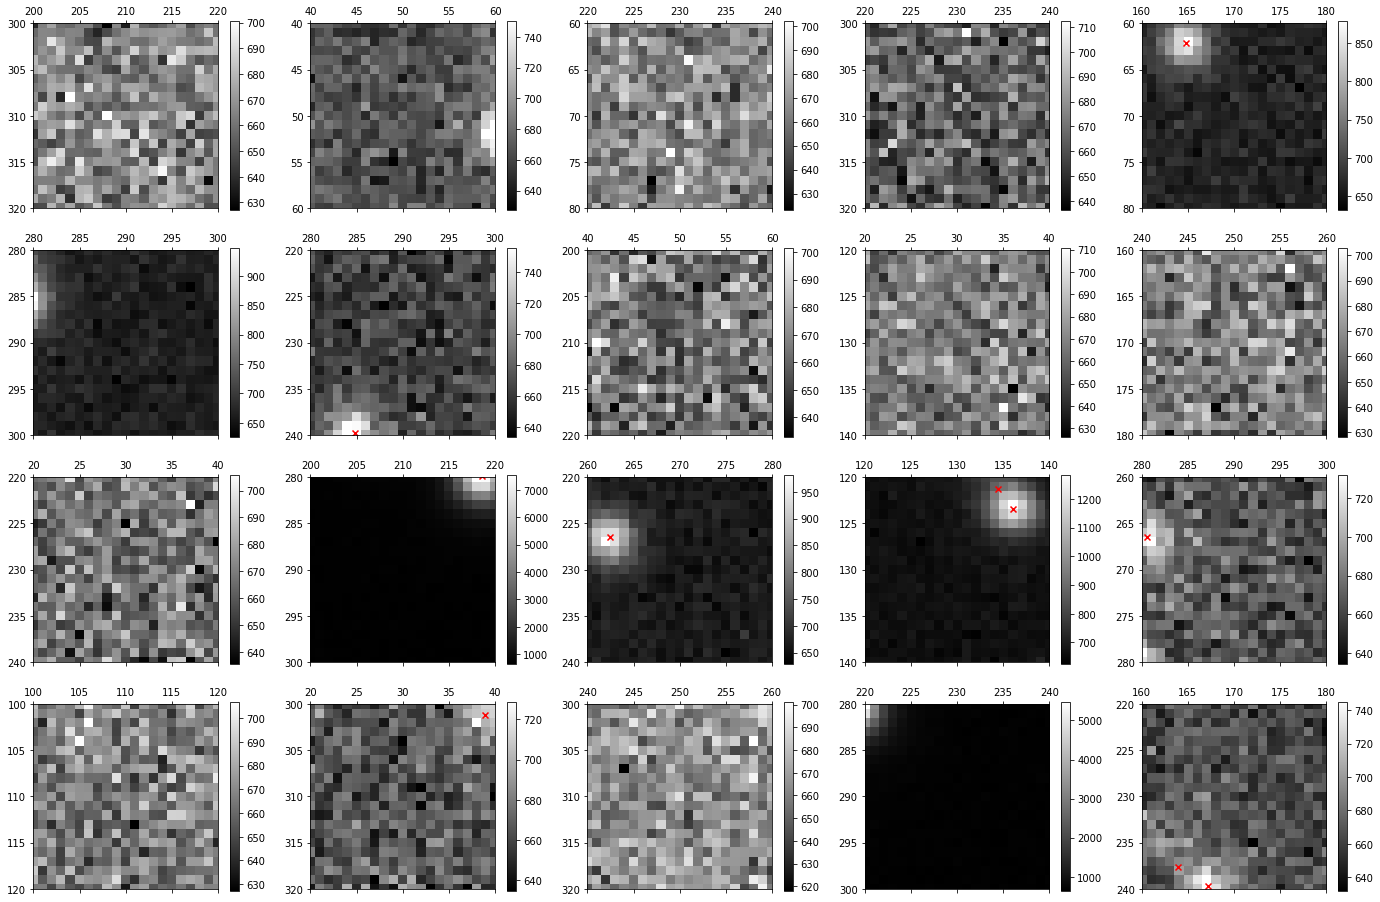

In [29]:
f, axarr = plt.subplots(4, 5, figsize=(24, 16))

# np.random.seed(3)

subimage_slen = 20
x0_vec = np.arange(x0, x0 + slen, subimage_slen)
x1_vec = np.arange(x1, x1 + slen, subimage_slen)

for i in range(20): 
    _x0 = np.random.choice(x0_vec)
    _x1 = np.random.choice(x1_vec)
        
    ax = axarr[i // 5,  i % 5]
    
    plotting.plot_locations(
        map_estimate['locs'], 
        ax,
        marker='x',
        color='r',
    )
    
        
    im = plotting.plot_image(ax, 
                             image[0, 0], 
                             _x0, 
                             _x1,
                             subimage_slen,
                             subimage_slen)
    
    f.colorbar(im, ax = ax)

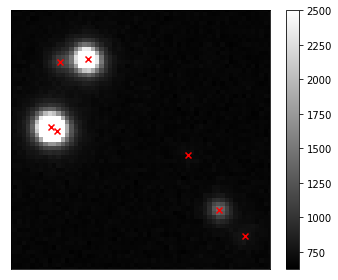

In [30]:
f, axarr = plt.subplots(1, 1, figsize=(5, 4))

# np.random.seed(3)
ax = axarr

plotting.plot_locations(
    map_estimate['locs'], 
    ax,
    marker='x',
    color='r',
)


im = plotting.plot_image(ax, 
                         image[0, 0].clip(max = 2500), 
                         20, 
                         80,
                         60,
                         60)

f.colorbar(im, ax = ax)

    
ax.set_xticks([])
ax.set_yticks([])

f.tight_layout();

f.savefig('../figures/decaps/example_subimage_decaps.png')

# Color magnitude diagrams

In [73]:
# give some border -- after borders may be zero-padded
border = 20
image_cmd = plotting.crop_image(image, 
                                border, 
                                border,
                                image.shape[-2] - 2 * border,
                                image.shape[-1] - 2 * border)

In [74]:
image_cmd.shape

torch.Size([1, 2, 4054, 2006])

In [75]:
test_im_slen = 100

In [76]:
x0_vec = np.arange(border_padding, 
                   image_cmd.shape[-2] - test_im_slen - border_padding, 
                   test_im_slen)

x1_vec = np.arange(border_padding, 
                   image_cmd.shape[-1] - test_im_slen - border_padding, 
                   test_im_slen)

In [77]:
t0 = time.time()

i = 0
for i in range(len(x0_vec)): 
    for j in range(len(x1_vec)): 
        _x0 = x0_vec[i]
        _x1 = x1_vec[j]
        
        # print('x0: ' + str(_x0) + '; ' + 'x1: ', str(_x1))
        
        test_image = \
            plotting.crop_image(image_cmd, 
                                _x0 - border_padding, 
                                _x1 - border_padding,
                                test_im_slen + 2 * border_padding,
                                test_im_slen + 2 * border_padding)
        
        map_estimate = get_map_estimate(sleep_net.image_encoder, 
                                        test_image.to(device),
                                        dataset.background.view(1, 2, 1, 1).to(device), 
                                        slen = test_im_slen)
        
        log_fluxes_i = torch.log10(map_estimate['fluxes'])
        log_fluxes_i = log_fluxes_i.squeeze(0).detach().cpu().numpy()
        
        if((i == 0) & (j == 0)): 
            log_fluxes = log_fluxes_i
        else: 
            log_fluxes = np.vstack([log_fluxes, log_fluxes_i])

print('done.')

print(time.time() - t0)

done.
4.023317337036133


In [35]:
log_fluxes.shape

(11878, 2)

In [36]:
11878 / (40 * 20)

14.8475

In [37]:
axis_label_size = 20
ticksize = 12
legendsize = 12
markersize = 10
linewidth = 2
titlesize = 18

In [38]:
mags = 22.5 - 2.5 * log_fluxes

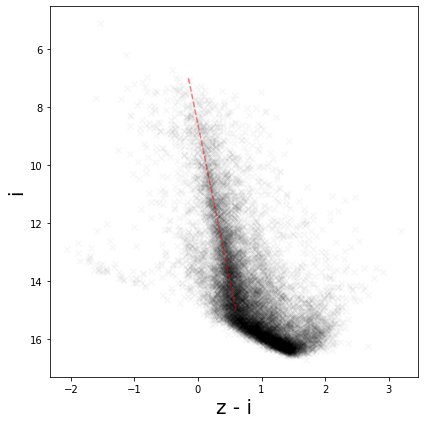

In [39]:
f, axarr = plt.subplots(1, 1, figsize=(6, 6))


axarr.scatter(mags[:, 1] - mags[:, 0], 
              mags[:, 1], 
              alpha = 0.03, 
              marker = 'x', 
              color = 'black')
axarr.set_ylabel('i', fontsize = axis_label_size)
axarr.set_xlabel('z - i', fontsize = axis_label_size)
axarr.set_ylim(axarr.get_ylim()[::-1])

t = np.linspace(0, 1, 100)
i0 = 7.
i1 = 15
zi0 = -0.15
zi1 = 0.6
y0 = zi0 + (zi1 - zi0) * t
y1 = i0 + (i1 - i0) * t

axarr.plot(y0, y1, 
           color = 'red', 
           linestyle = 'dashed',
           alpha = 0.5)

f.tight_layout()
f.savefig('../figures/decaps/decaps_cmd.png')

In [38]:
# plt.hist(log_fluxes[:, 1])